# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29835.12890625
iteration 0 loss 25886.728515625


iteration 500 loss 374.029052734375


iteration 1000 loss 299.9454040527344


iteration 1500 loss 253.18724060058594


iteration 2000 loss 226.5022430419922


iteration 2500 loss 212.7835693359375


iteration 3000 loss 205.026123046875


iteration 3500 loss 198.48594665527344


iteration 4000 loss 191.37948608398438


iteration 4500 loss 183.36920166015625


iteration 5000 loss 174.32859802246094


iteration 5500 loss 164.06410217285156


iteration 6000 loss 152.20054626464844


iteration 6500 loss 137.871826171875


iteration 7000 loss 119.39834594726562


iteration 7500 loss 93.26524353027344


iteration 8000 loss 58.724159240722656


iteration 8500 loss 36.75223159790039


iteration 9000 loss 27.62745475769043


iteration 9500 loss 23.065570831298828


iteration 10000 loss 20.40917205810547


iteration 10500 loss 18.54714012145996


iteration 11000 loss 17.285856246948242


iteration 11500 loss 16.312021255493164


iteration 12000 loss 15.521915435791016


iteration 12500 loss 14.867060661315918


iteration 13000 loss 14.28096866607666


iteration 13500 loss 13.747004508972168


iteration 14000 loss 13.224146842956543


iteration 14500 loss 12.718210220336914


iteration 15000 loss 12.254972457885742


iteration 15500 loss 11.75861644744873


iteration 16000 loss 11.292448043823242


iteration 16500 loss 10.81130599975586


iteration 17000 loss 10.311077117919922


iteration 17500 loss 9.790854454040527


iteration 18000 loss 9.322513580322266


iteration 18500 loss 8.798172950744629


iteration 19000 loss 8.27008056640625


iteration 19500 loss 7.737514019012451


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 7.204942226409912


iteration 20500 loss 7.14518404006958


iteration 21000 loss 7.068546772003174


iteration 21500 loss 6.970495700836182


iteration 22000 loss 6.845666885375977


iteration 22500 loss 6.6880340576171875


iteration 23000 loss 6.491388320922852


iteration 23500 loss 6.250238418579102


iteration 24000 loss 5.962465763092041


iteration 24500 loss 5.647953033447266


iteration 25000 loss 5.323718070983887


iteration 25500 loss 5.005523204803467


iteration 26000 loss 4.702619552612305


iteration 26500 loss 4.415921688079834


iteration 27000 loss 4.147374153137207


iteration 27500 loss 3.897853136062622


iteration 28000 loss 3.667456865310669


iteration 28500 loss 3.4551212787628174


iteration 29000 loss 3.260378837585449


iteration 29500 loss 3.0801854133605957


iteration 30000 loss 2.9133706092834473


iteration 30500 loss 2.7594962120056152


iteration 31000 loss 2.6180307865142822


iteration 31500 loss 2.48690128326416


iteration 32000 loss 2.365994930267334


iteration 32500 loss 2.2538228034973145


iteration 33000 loss 2.149885892868042


iteration 33500 loss 2.053797721862793


iteration 34000 loss 1.9639354944229126


iteration 34500 loss 1.8807098865509033


iteration 35000 loss 1.8024319410324097


iteration 35500 loss 1.7298229932785034


iteration 36000 loss 1.6622437238693237


iteration 36500 loss 1.6008296012878418


iteration 37000 loss 1.54123055934906


iteration 37500 loss 1.4858410358428955


iteration 38000 loss 1.4343804121017456


iteration 38500 loss 1.3876121044158936


iteration 39000 loss 1.3404455184936523


iteration 39500 loss 1.297876000404358


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 1.257904052734375


iteration 40500 loss 1.2534141540527344


iteration 41000 loss 1.2479629516601562


iteration 41500 loss 1.2412562370300293


iteration 42000 loss 1.2331180572509766


iteration 42500 loss 1.2234008312225342


iteration 43000 loss 1.2120091915130615


iteration 43500 loss 1.198919653892517


iteration 44000 loss 1.1841930150985718


iteration 44500 loss 1.1679794788360596


iteration 45000 loss 1.1512686014175415


iteration 45500 loss 1.1348730325698853


iteration 46000 loss 1.118945837020874


iteration 46500 loss 1.1035016775131226


iteration 47000 loss 1.0884827375411987


iteration 47500 loss 1.0738677978515625


iteration 48000 loss 1.0596390962600708


iteration 48500 loss 1.0457804203033447


iteration 49000 loss 1.0322495698928833


iteration 49500 loss 1.0190614461898804


iteration 50000 loss 1.006197452545166


iteration 50500 loss 0.993621826171875


iteration 51000 loss 0.9813124537467957


iteration 51500 loss 0.9692938923835754


iteration 52000 loss 0.9575192928314209


iteration 52500 loss 0.9460228085517883


iteration 53000 loss 0.9347927570343018


iteration 53500 loss 0.9237927794456482


iteration 54000 loss 0.9130370616912842


iteration 54500 loss 0.9025235176086426


iteration 55000 loss 0.8922404050827026


iteration 55500 loss 0.882186233997345


iteration 56000 loss 0.8723414540290833


iteration 56500 loss 0.8627200126647949


iteration 57000 loss 0.8533085584640503


iteration 57500 loss 0.8441184163093567


iteration 58000 loss 0.8351119160652161


iteration 58500 loss 0.8263088464736938


iteration 59000 loss 0.8176844120025635


iteration 59500 loss 0.8092600107192993


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.8010178208351135


iteration 60500 loss 0.800146222114563


iteration 61000 loss 0.7991821765899658


iteration 61500 loss 0.798114538192749


iteration 62000 loss 0.7969463467597961


iteration 62500 loss 0.7956856489181519


iteration 63000 loss 0.7943398356437683


iteration 63500 loss 0.7929185628890991


iteration 64000 loss 0.7914322018623352


iteration 64500 loss 0.7898944020271301


iteration 65000 loss 0.7883238196372986


iteration 65500 loss 0.7867664098739624


iteration 66000 loss 0.7852377891540527


iteration 66500 loss 0.7837335467338562


iteration 67000 loss 0.7822524309158325


iteration 67500 loss 0.7807911038398743


iteration 68000 loss 0.7793479561805725


iteration 68500 loss 0.7779204845428467


iteration 69000 loss 0.7765085697174072


iteration 69500 loss 0.7751107215881348


iteration 70000 loss 0.7737264037132263


iteration 70500 loss 0.7723543047904968


iteration 71000 loss 0.7709939479827881


iteration 71500 loss 0.7696442008018494


iteration 72000 loss 0.7683050036430359


iteration 72500 loss 0.7669764161109924


iteration 73000 loss 0.7656577229499817


iteration 73500 loss 0.7643476128578186


iteration 74000 loss 0.7630468606948853


iteration 74500 loss 0.7617540955543518


iteration 75000 loss 0.7604698538780212


iteration 75500 loss 0.7591930627822876


iteration 76000 loss 0.7579243183135986


iteration 76500 loss 0.756662905216217


iteration 77000 loss 0.7554087042808533


iteration 77500 loss 0.75416100025177


iteration 78000 loss 0.7529202103614807


iteration 78500 loss 0.7516857981681824


iteration 79000 loss 0.7504575252532959


iteration 79500 loss 0.7492350339889526


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.7480193376541138


iteration 80500 loss 0.7479055523872375


iteration 81000 loss 0.7477885484695435


iteration 81500 loss 0.7476687431335449


iteration 82000 loss 0.7475461959838867


iteration 82500 loss 0.7474217414855957


iteration 83000 loss 0.747295081615448


iteration 83500 loss 0.7471677660942078


iteration 84000 loss 0.7470393776893616


iteration 84500 loss 0.7469105124473572


iteration 85000 loss 0.7467819452285767


iteration 85500 loss 0.7466533184051514


iteration 86000 loss 0.7465254664421082


iteration 86500 loss 0.7463981509208679


iteration 87000 loss 0.7462710738182068


iteration 87500 loss 0.7461455464363098


iteration 88000 loss 0.7460198402404785


iteration 88500 loss 0.7458950877189636


iteration 89000 loss 0.745770275592804


iteration 89500 loss 0.7456458210945129


iteration 90000 loss 0.7455223202705383


iteration 90500 loss 0.7453989386558533


iteration 91000 loss 0.7452755570411682


iteration 91500 loss 0.7451526522636414


iteration 92000 loss 0.7450300455093384


iteration 92500 loss 0.7449079751968384


iteration 93000 loss 0.7447862029075623


iteration 93500 loss 0.7446646094322205


iteration 94000 loss 0.7445428967475891


iteration 94500 loss 0.744421660900116


iteration 95000 loss 0.7443010807037354


iteration 95500 loss 0.7441800832748413


iteration 96000 loss 0.7440595626831055


iteration 96500 loss 0.7439387440681458


iteration 97000 loss 0.7438182234764099


iteration 97500 loss 0.7436982989311218


iteration 98000 loss 0.7435780167579651


iteration 98500 loss 0.7434577941894531


iteration 99000 loss 0.7433382868766785


iteration 99500 loss 0.7432184219360352


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.7430990934371948


iteration 100500 loss 0.7430935502052307


iteration 101000 loss 0.7430875897407532


iteration 101500 loss 0.7430815100669861


iteration 102000 loss 0.7430754899978638


iteration 102500 loss 0.7430697083473206


iteration 103000 loss 0.7430638074874878


iteration 103500 loss 0.7430576682090759


iteration 104000 loss 0.7430516481399536


iteration 104500 loss 0.7430458068847656


iteration 105000 loss 0.7430397868156433


iteration 105500 loss 0.7430339455604553


iteration 106000 loss 0.7430281043052673


iteration 106500 loss 0.7430217266082764


iteration 107000 loss 0.7430160045623779


iteration 107500 loss 0.7430100440979004


iteration 108000 loss 0.7430043816566467


iteration 108500 loss 0.742998480796814


iteration 109000 loss 0.7429922819137573


iteration 109500 loss 0.7429865002632141


iteration 110000 loss 0.7429807186126709


iteration 110500 loss 0.7429747581481934


iteration 111000 loss 0.742969274520874


iteration 111500 loss 0.7429631352424622


iteration 112000 loss 0.7429574728012085


iteration 112500 loss 0.7429514527320862


iteration 113000 loss 0.7429456114768982


iteration 113500 loss 0.7429396510124207


iteration 114000 loss 0.7429340481758118


iteration 114500 loss 0.742928147315979


iteration 115000 loss 0.7429221868515015


iteration 115500 loss 0.7429163455963135


iteration 116000 loss 0.7429104447364807


iteration 116500 loss 0.7429046034812927


iteration 117000 loss 0.7428990006446838


iteration 117500 loss 0.7428932189941406


iteration 118000 loss 0.7428876757621765


iteration 118500 loss 0.742881715297699


iteration 119000 loss 0.7428757548332214


iteration 119500 loss 0.7428699135780334


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.7428643107414246


iteration 120500 loss 0.7428641319274902


iteration 121000 loss 0.7428639531135559


iteration 121500 loss 0.7428638339042664


iteration 122000 loss 0.742863655090332


iteration 122500 loss 0.7428639531135559


iteration 123000 loss 0.7428639531135559


iteration 123500 loss 0.7428638339042664


iteration 124000 loss 0.7428639531135559


iteration 124500 loss 0.7428637146949768


iteration 125000 loss 0.742863655090332


iteration 125500 loss 0.7428637742996216


iteration 126000 loss 0.7428635358810425


iteration 126500 loss 0.7428635358810425


iteration 127000 loss 0.7428634166717529


iteration 127500 loss 0.7428635358810425


iteration 128000 loss 0.742863118648529


iteration 128500 loss 0.7428631782531738


iteration 129000 loss 0.74286288022995


iteration 129500 loss 0.7428629994392395


iteration 130000 loss 0.7428629398345947


iteration 130500 loss 0.74286288022995


iteration 131000 loss 0.7428629398345947


iteration 131500 loss 0.7428625822067261


iteration 132000 loss 0.7428627610206604


iteration 132500 loss 0.7428627014160156


iteration 133000 loss 0.7428627014160156


iteration 133500 loss 0.7428627014160156


iteration 134000 loss 0.7428627014160156


iteration 134500 loss 0.7428627014160156


iteration 135000 loss 0.7428625822067261


iteration 135500 loss 0.7428624033927917


iteration 136000 loss 0.7428624033927917


iteration 136500 loss 0.7428622841835022


iteration 137000 loss 0.7428621649742126


iteration 137500 loss 0.742862343788147


iteration 138000 loss 0.7428621649742126


iteration 138500 loss 0.7428618669509888


iteration 139000 loss 0.7428620457649231


iteration 139500 loss 0.7428618669509888


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.742861807346344


iteration 140500 loss 0.7428619861602783


iteration 141000 loss 0.7428618669509888


iteration 141500 loss 0.7428618669509888


iteration 142000 loss 0.7428619265556335


iteration 142500 loss 0.7428616285324097


iteration 143000 loss 0.7428616285324097


iteration 143500 loss 0.742861807346344


iteration 144000 loss 0.7428618669509888


iteration 144500 loss 0.7428619861602783


iteration 145000 loss 0.742861807346344


iteration 145500 loss 0.7428622245788574


iteration 146000 loss 0.7428618669509888


iteration 146500 loss 0.7428618669509888


iteration 147000 loss 0.7428618669509888


iteration 147500 loss 0.7428618669509888


iteration 148000 loss 0.7428618669509888


iteration 148500 loss 0.7428619861602783


iteration 149000 loss 0.7428620457649231


iteration 149500 loss 0.7428618669509888


iteration 150000 loss 0.7428618669509888


iteration 150500 loss 0.7428619265556335


iteration 151000 loss 0.7428619861602783


iteration 151500 loss 0.7428619861602783


iteration 152000 loss 0.7428618669509888


iteration 152500 loss 0.7428618669509888


iteration 153000 loss 0.7428619265556335


iteration 153500 loss 0.7428619265556335


iteration 154000 loss 0.7428618669509888


iteration 154500 loss 0.7428618669509888


iteration 155000 loss 0.7428619265556335


iteration 155500 loss 0.7428619861602783


iteration 156000 loss 0.7428618669509888


iteration 156500 loss 0.742861807346344


iteration 157000 loss 0.7428618669509888


iteration 157500 loss 0.7428619861602783


iteration 158000 loss 0.7428619861602783


iteration 158500 loss 0.7428619861602783


iteration 159000 loss 0.7428617477416992


iteration 159500 loss 0.7428618669509888


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.7428619861602783


iteration 160500 loss 0.7428619861602783


iteration 161000 loss 0.7428619861602783


iteration 161500 loss 0.7428619861602783


iteration 162000 loss 0.7428619861602783


iteration 162500 loss 0.7428620457649231


iteration 163000 loss 0.7428619861602783


iteration 163500 loss 0.7428619861602783


iteration 164000 loss 0.7428619861602783


iteration 164500 loss 0.7428619861602783


iteration 165000 loss 0.7428620457649231


iteration 165500 loss 0.7428620457649231


iteration 166000 loss 0.7428619861602783


iteration 166500 loss 0.7428620457649231


iteration 167000 loss 0.7428619861602783


iteration 167500 loss 0.7428619861602783


iteration 168000 loss 0.7428619861602783


iteration 168500 loss 0.7428619861602783


iteration 169000 loss 0.7428619861602783


iteration 169500 loss 0.7428619861602783


iteration 170000 loss 0.7428620457649231


iteration 170500 loss 0.7428619861602783


iteration 171000 loss 0.7428620457649231


iteration 171500 loss 0.7428619861602783


iteration 172000 loss 0.7428619861602783


iteration 172500 loss 0.7428619861602783


iteration 173000 loss 0.7428619861602783


iteration 173500 loss 0.7428620457649231


iteration 174000 loss 0.7428619861602783


iteration 174500 loss 0.7428619861602783


iteration 175000 loss 0.7428619861602783


iteration 175500 loss 0.7428619265556335


iteration 176000 loss 0.7428619861602783


iteration 176500 loss 0.7428619861602783


iteration 177000 loss 0.7428619861602783


iteration 177500 loss 0.7428619861602783


iteration 178000 loss 0.7428619861602783


iteration 178500 loss 0.7428619265556335


iteration 179000 loss 0.7428619861602783


iteration 179500 loss 0.7428619861602783


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.7428619265556335


iteration 180500 loss 0.7428619265556335


iteration 181000 loss 0.7428619265556335


iteration 181500 loss 0.7428619265556335


iteration 182000 loss 0.7428619265556335


iteration 182500 loss 0.7428619265556335


iteration 183000 loss 0.7428619265556335


iteration 183500 loss 0.7428619265556335


iteration 184000 loss 0.7428619265556335


iteration 184500 loss 0.7428619265556335


iteration 185000 loss 0.7428619265556335


iteration 185500 loss 0.7428619265556335


iteration 186000 loss 0.7428619265556335


iteration 186500 loss 0.7428619265556335


iteration 187000 loss 0.7428619265556335


iteration 187500 loss 0.7428619265556335


iteration 188000 loss 0.7428619265556335


iteration 188500 loss 0.7428619265556335


iteration 189000 loss 0.7428619265556335


iteration 189500 loss 0.7428619265556335


iteration 190000 loss 0.7428619265556335


iteration 190500 loss 0.7428619265556335


iteration 191000 loss 0.7428619265556335


iteration 191500 loss 0.7428619265556335


iteration 192000 loss 0.7428619265556335


iteration 192500 loss 0.7428619265556335


iteration 193000 loss 0.7428619265556335


iteration 193500 loss 0.7428619265556335


iteration 194000 loss 0.7428619265556335


iteration 194500 loss 0.7428619265556335


iteration 195000 loss 0.7428619265556335


iteration 195500 loss 0.7428619265556335


iteration 196000 loss 0.7428619265556335


iteration 196500 loss 0.7428619265556335


iteration 197000 loss 0.7428619265556335


iteration 197500 loss 0.7428619265556335


iteration 198000 loss 0.7428619265556335


iteration 198500 loss 0.7428619265556335


iteration 199000 loss 0.7428619265556335


iteration 199500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.7428619265556335


iteration 200500 loss 0.7428619265556335


iteration 201000 loss 0.7428619265556335


iteration 201500 loss 0.7428619265556335


iteration 202000 loss 0.7428619265556335


iteration 202500 loss 0.7428619265556335


iteration 203000 loss 0.7428619265556335


iteration 203500 loss 0.7428619265556335


iteration 204000 loss 0.7428619265556335


iteration 204500 loss 0.7428619265556335


iteration 205000 loss 0.7428619265556335


iteration 205500 loss 0.7428619265556335


iteration 206000 loss 0.7428619265556335


iteration 206500 loss 0.7428619265556335


iteration 207000 loss 0.7428619265556335


iteration 207500 loss 0.7428619265556335


iteration 208000 loss 0.7428619265556335


iteration 208500 loss 0.7428619265556335


iteration 209000 loss 0.7428619265556335


iteration 209500 loss 0.7428619265556335


iteration 210000 loss 0.7428619265556335


iteration 210500 loss 0.7428619265556335


iteration 211000 loss 0.7428619265556335


iteration 211500 loss 0.7428619265556335


iteration 212000 loss 0.7428619265556335


iteration 212500 loss 0.7428619265556335


iteration 213000 loss 0.7428619265556335


iteration 213500 loss 0.7428619265556335


iteration 214000 loss 0.7428619265556335


iteration 214500 loss 0.7428619265556335


iteration 215000 loss 0.7428619265556335


iteration 215500 loss 0.7428619265556335


iteration 216000 loss 0.7428619265556335


iteration 216500 loss 0.7428619265556335


iteration 217000 loss 0.7428619265556335


iteration 217500 loss 0.7428619265556335


iteration 218000 loss 0.7428619265556335


iteration 218500 loss 0.7428619265556335


iteration 219000 loss 0.7428619265556335


iteration 219500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.7428619265556335


iteration 220500 loss 0.7428619265556335


iteration 221000 loss 0.7428619265556335


iteration 221500 loss 0.7428619265556335


iteration 222000 loss 0.7428619265556335


iteration 222500 loss 0.7428619265556335


iteration 223000 loss 0.7428619265556335


iteration 223500 loss 0.7428619265556335


iteration 224000 loss 0.7428619265556335


iteration 224500 loss 0.7428619265556335


iteration 225000 loss 0.7428619265556335


iteration 225500 loss 0.7428619265556335


iteration 226000 loss 0.7428619265556335


iteration 226500 loss 0.7428619265556335


iteration 227000 loss 0.7428619265556335


iteration 227500 loss 0.7428619265556335


iteration 228000 loss 0.7428619265556335


iteration 228500 loss 0.7428619265556335


iteration 229000 loss 0.7428619265556335


iteration 229500 loss 0.7428619265556335


iteration 230000 loss 0.7428619265556335


iteration 230500 loss 0.7428619265556335


iteration 231000 loss 0.7428619265556335


iteration 231500 loss 0.7428619265556335


iteration 232000 loss 0.7428619265556335


iteration 232500 loss 0.7428619265556335


iteration 233000 loss 0.7428619265556335


iteration 233500 loss 0.7428619265556335


iteration 234000 loss 0.7428619265556335


iteration 234500 loss 0.7428619265556335


iteration 235000 loss 0.7428619265556335


iteration 235500 loss 0.7428619265556335


iteration 236000 loss 0.7428619265556335


iteration 236500 loss 0.7428619265556335


iteration 237000 loss 0.7428619265556335


iteration 237500 loss 0.7428619265556335


iteration 238000 loss 0.7428619265556335


iteration 238500 loss 0.7428619265556335


iteration 239000 loss 0.7428619265556335


iteration 239500 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.7428619265556335


iteration 240500 loss 0.7428619265556335


iteration 241000 loss 0.7428619265556335


iteration 241500 loss 0.7428619265556335


iteration 242000 loss 0.7428619265556335


iteration 242500 loss 0.7428619265556335


iteration 243000 loss 0.7428619265556335


iteration 243500 loss 0.7428619265556335


iteration 244000 loss 0.7428619265556335


iteration 244500 loss 0.7428619265556335


iteration 245000 loss 0.7428619265556335


iteration 245500 loss 0.7428619265556335


iteration 246000 loss 0.7428619265556335


iteration 246500 loss 0.7428619265556335


iteration 247000 loss 0.7428619265556335


iteration 247500 loss 0.7428619265556335


iteration 248000 loss 0.7428619265556335


iteration 248500 loss 0.7428619265556335


iteration 249000 loss 0.7428619265556335


iteration 249500 loss 0.7428619265556335


iteration 250000 loss 0.7428619265556335


iteration 250500 loss 0.7428619265556335


iteration 251000 loss 0.7428619265556335


iteration 251500 loss 0.7428619265556335


iteration 252000 loss 0.7428619265556335


iteration 252500 loss 0.7428619265556335


iteration 253000 loss 0.7428619265556335


iteration 253500 loss 0.7428619265556335


iteration 254000 loss 0.7428619265556335


iteration 254500 loss 0.7428619265556335


iteration 255000 loss 0.7428619265556335


iteration 255500 loss 0.7428619265556335


iteration 256000 loss 0.7428619265556335


iteration 256500 loss 0.7428619265556335


iteration 257000 loss 0.7428619265556335


iteration 257500 loss 0.7428619265556335


iteration 258000 loss 0.7428619265556335


iteration 258500 loss 0.7428619265556335


iteration 259000 loss 0.7428619265556335


iteration 259500 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.7428619265556335


iteration 260500 loss 0.7428619265556335


iteration 261000 loss 0.7428619265556335


iteration 261500 loss 0.7428619265556335


iteration 262000 loss 0.7428619265556335


iteration 262500 loss 0.7428619265556335


iteration 263000 loss 0.7428619265556335


iteration 263500 loss 0.7428619265556335


iteration 264000 loss 0.7428619265556335


iteration 264500 loss 0.7428619265556335


iteration 265000 loss 0.7428619265556335


iteration 265500 loss 0.7428619265556335


iteration 266000 loss 0.7428619265556335


iteration 266500 loss 0.7428619265556335


iteration 267000 loss 0.7428619265556335


iteration 267500 loss 0.7428619265556335


iteration 268000 loss 0.7428619265556335


iteration 268500 loss 0.7428619265556335


iteration 269000 loss 0.7428619265556335


iteration 269500 loss 0.7428619265556335


iteration 270000 loss 0.7428619265556335


iteration 270500 loss 0.7428619265556335


iteration 271000 loss 0.7428619265556335


iteration 271500 loss 0.7428619265556335


iteration 272000 loss 0.7428619265556335


iteration 272500 loss 0.7428619265556335


iteration 273000 loss 0.7428619265556335


iteration 273500 loss 0.7428619265556335


iteration 274000 loss 0.7428619265556335


iteration 274500 loss 0.7428619265556335


iteration 275000 loss 0.7428619265556335


iteration 275500 loss 0.7428619265556335


iteration 276000 loss 0.7428619265556335


iteration 276500 loss 0.7428619265556335


iteration 277000 loss 0.7428619265556335


iteration 277500 loss 0.7428619265556335


iteration 278000 loss 0.7428619265556335


iteration 278500 loss 0.7428619265556335


iteration 279000 loss 0.7428619265556335


iteration 279500 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.7428619265556335


iteration 280500 loss 0.7428619265556335


iteration 281000 loss 0.7428619265556335


iteration 281500 loss 0.7428619265556335


iteration 282000 loss 0.7428619265556335


iteration 282500 loss 0.7428619265556335


iteration 283000 loss 0.7428619265556335


iteration 283500 loss 0.7428619265556335


iteration 284000 loss 0.7428619265556335


iteration 284500 loss 0.7428619265556335


iteration 285000 loss 0.7428619265556335


iteration 285500 loss 0.7428619265556335


iteration 286000 loss 0.7428619265556335


iteration 286500 loss 0.7428619265556335


iteration 287000 loss 0.7428619265556335


iteration 287500 loss 0.7428619265556335


iteration 288000 loss 0.7428619265556335


iteration 288500 loss 0.7428619265556335


iteration 289000 loss 0.7428619265556335


iteration 289500 loss 0.7428619265556335


iteration 290000 loss 0.7428619265556335


iteration 290500 loss 0.7428619265556335


iteration 291000 loss 0.7428619265556335


iteration 291500 loss 0.7428619265556335


iteration 292000 loss 0.7428619265556335


iteration 292500 loss 0.7428619265556335


iteration 293000 loss 0.7428619265556335


iteration 293500 loss 0.7428619265556335


iteration 294000 loss 0.7428619265556335


iteration 294500 loss 0.7428619265556335


iteration 295000 loss 0.7428619265556335


iteration 295500 loss 0.7428619265556335


iteration 296000 loss 0.7428619265556335


iteration 296500 loss 0.7428619265556335


iteration 297000 loss 0.7428619265556335


iteration 297500 loss 0.7428619265556335


iteration 298000 loss 0.7428619265556335


iteration 298500 loss 0.7428619265556335


iteration 299000 loss 0.7428619265556335


iteration 299500 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.7428619265556335


iteration 300500 loss 0.7428619265556335


iteration 301000 loss 0.7428619265556335


iteration 301500 loss 0.7428619265556335


iteration 302000 loss 0.7428619265556335


iteration 302500 loss 0.7428619265556335


iteration 303000 loss 0.7428619265556335


iteration 303500 loss 0.7428619265556335


iteration 304000 loss 0.7428619265556335


iteration 304500 loss 0.7428619265556335


iteration 305000 loss 0.7428619265556335


iteration 305500 loss 0.7428619265556335


iteration 306000 loss 0.7428619265556335


iteration 306500 loss 0.7428619265556335


iteration 307000 loss 0.7428619265556335


iteration 307500 loss 0.7428619265556335


iteration 308000 loss 0.7428619265556335


iteration 308500 loss 0.7428619265556335


iteration 309000 loss 0.7428619265556335


iteration 309500 loss 0.7428619265556335


iteration 310000 loss 0.7428619265556335


iteration 310500 loss 0.7428619265556335


iteration 311000 loss 0.7428619265556335


iteration 311500 loss 0.7428619265556335


iteration 312000 loss 0.7428619265556335


iteration 312500 loss 0.7428619265556335


iteration 313000 loss 0.7428619265556335


iteration 313500 loss 0.7428619265556335


iteration 314000 loss 0.7428619265556335


iteration 314500 loss 0.7428619265556335


iteration 315000 loss 0.7428619265556335


iteration 315500 loss 0.7428619265556335


iteration 316000 loss 0.7428619265556335


iteration 316500 loss 0.7428619265556335


iteration 317000 loss 0.7428619265556335


iteration 317500 loss 0.7428619265556335


iteration 318000 loss 0.7428619265556335


iteration 318500 loss 0.7428619265556335


iteration 319000 loss 0.7428619265556335


iteration 319500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.7428619265556335


iteration 320500 loss 0.7428619265556335


iteration 321000 loss 0.7428619265556335


iteration 321500 loss 0.7428619265556335


iteration 322000 loss 0.7428619265556335


iteration 322500 loss 0.7428619265556335


iteration 323000 loss 0.7428619265556335


iteration 323500 loss 0.7428619265556335


iteration 324000 loss 0.7428619265556335


iteration 324500 loss 0.7428619265556335


iteration 325000 loss 0.7428619265556335


iteration 325500 loss 0.7428619265556335


iteration 326000 loss 0.7428619265556335


iteration 326500 loss 0.7428619265556335


iteration 327000 loss 0.7428619265556335


iteration 327500 loss 0.7428619265556335


iteration 328000 loss 0.7428619265556335


iteration 328500 loss 0.7428619265556335


iteration 329000 loss 0.7428619265556335


iteration 329500 loss 0.7428619265556335


iteration 330000 loss 0.7428619265556335


iteration 330500 loss 0.7428619265556335


iteration 331000 loss 0.7428619265556335


iteration 331500 loss 0.7428619265556335


iteration 332000 loss 0.7428619265556335


iteration 332500 loss 0.7428619265556335


iteration 333000 loss 0.7428619265556335


iteration 333500 loss 0.7428619265556335


iteration 334000 loss 0.7428619265556335


iteration 334500 loss 0.7428619265556335


iteration 335000 loss 0.7428619265556335


iteration 335500 loss 0.7428619265556335


iteration 336000 loss 0.7428619265556335


iteration 336500 loss 0.7428619265556335


iteration 337000 loss 0.7428619265556335


iteration 337500 loss 0.7428619265556335


iteration 338000 loss 0.7428619265556335


iteration 338500 loss 0.7428619265556335


iteration 339000 loss 0.7428619265556335


iteration 339500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.7428619265556335


iteration 340500 loss 0.7428619265556335


iteration 341000 loss 0.7428619265556335


iteration 341500 loss 0.7428619265556335


iteration 342000 loss 0.7428619265556335


iteration 342500 loss 0.7428619265556335


iteration 343000 loss 0.7428619265556335


iteration 343500 loss 0.7428619265556335


iteration 344000 loss 0.7428619265556335


iteration 344500 loss 0.7428619265556335


iteration 345000 loss 0.7428619265556335


iteration 345500 loss 0.7428619265556335


iteration 346000 loss 0.7428619265556335


iteration 346500 loss 0.7428619265556335


iteration 347000 loss 0.7428619265556335


iteration 347500 loss 0.7428619265556335


iteration 348000 loss 0.7428619265556335


iteration 348500 loss 0.7428619265556335


iteration 349000 loss 0.7428619265556335


iteration 349500 loss 0.7428619265556335


iteration 350000 loss 0.7428619265556335


iteration 350500 loss 0.7428619265556335


iteration 351000 loss 0.7428619265556335


iteration 351500 loss 0.7428619265556335


iteration 352000 loss 0.7428619265556335


iteration 352500 loss 0.7428619265556335


iteration 353000 loss 0.7428619265556335


iteration 353500 loss 0.7428619265556335


iteration 354000 loss 0.7428619265556335


iteration 354500 loss 0.7428619265556335


iteration 355000 loss 0.7428619265556335


iteration 355500 loss 0.7428619265556335


iteration 356000 loss 0.7428619265556335


iteration 356500 loss 0.7428619265556335


iteration 357000 loss 0.7428619265556335


iteration 357500 loss 0.7428619265556335


iteration 358000 loss 0.7428619265556335


iteration 358500 loss 0.7428619265556335


iteration 359000 loss 0.7428619265556335


iteration 359500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.7428619265556335


iteration 360500 loss 0.7428619265556335


iteration 361000 loss 0.7428619265556335


iteration 361500 loss 0.7428619265556335


iteration 362000 loss 0.7428619265556335


iteration 362500 loss 0.7428619265556335


iteration 363000 loss 0.7428619265556335


iteration 363500 loss 0.7428619265556335


iteration 364000 loss 0.7428619265556335


iteration 364500 loss 0.7428619265556335


iteration 365000 loss 0.7428619265556335


iteration 365500 loss 0.7428619265556335


iteration 366000 loss 0.7428619265556335


iteration 366500 loss 0.7428619265556335


iteration 367000 loss 0.7428619265556335


iteration 367500 loss 0.7428619265556335


iteration 368000 loss 0.7428619265556335


iteration 368500 loss 0.7428619265556335


iteration 369000 loss 0.7428619265556335


iteration 369500 loss 0.7428619265556335


iteration 370000 loss 0.7428619265556335


iteration 370500 loss 0.7428619265556335


iteration 371000 loss 0.7428619265556335


iteration 371500 loss 0.7428619265556335


iteration 372000 loss 0.7428619265556335


iteration 372500 loss 0.7428619265556335


iteration 373000 loss 0.7428619265556335


iteration 373500 loss 0.7428619265556335


iteration 374000 loss 0.7428619265556335


iteration 374500 loss 0.7428619265556335


iteration 375000 loss 0.7428619265556335


iteration 375500 loss 0.7428619265556335


iteration 376000 loss 0.7428619265556335


iteration 376500 loss 0.7428619265556335


iteration 377000 loss 0.7428619265556335


iteration 377500 loss 0.7428619265556335


iteration 378000 loss 0.7428619265556335


iteration 378500 loss 0.7428619265556335


iteration 379000 loss 0.7428619265556335


iteration 379500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.7428619265556335


iteration 380500 loss 0.7428619265556335


iteration 381000 loss 0.7428619265556335


iteration 381500 loss 0.7428619265556335


iteration 382000 loss 0.7428619265556335


iteration 382500 loss 0.7428619265556335


iteration 383000 loss 0.7428619265556335


iteration 383500 loss 0.7428619265556335


iteration 384000 loss 0.7428619265556335


iteration 384500 loss 0.7428619265556335


iteration 385000 loss 0.7428619265556335


iteration 385500 loss 0.7428619265556335


iteration 386000 loss 0.7428619265556335


iteration 386500 loss 0.7428619265556335


iteration 387000 loss 0.7428619265556335


iteration 387500 loss 0.7428619265556335


iteration 388000 loss 0.7428619265556335


iteration 388500 loss 0.7428619265556335


iteration 389000 loss 0.7428619265556335


iteration 389500 loss 0.7428619265556335


iteration 390000 loss 0.7428619265556335


iteration 390500 loss 0.7428619265556335


iteration 391000 loss 0.7428619265556335


iteration 391500 loss 0.7428619265556335


iteration 392000 loss 0.7428619265556335


iteration 392500 loss 0.7428619265556335


iteration 393000 loss 0.7428619265556335


iteration 393500 loss 0.7428619265556335


iteration 394000 loss 0.7428619265556335


iteration 394500 loss 0.7428619265556335


iteration 395000 loss 0.7428619265556335


iteration 395500 loss 0.7428619265556335


iteration 396000 loss 0.7428619265556335


iteration 396500 loss 0.7428619265556335


iteration 397000 loss 0.7428619265556335


iteration 397500 loss 0.7428619265556335


iteration 398000 loss 0.7428619265556335


iteration 398500 loss 0.7428619265556335


iteration 399000 loss 0.7428619265556335


iteration 399500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.7428619265556335


iteration 400500 loss 0.7428619265556335


iteration 401000 loss 0.7428619265556335


iteration 401500 loss 0.7428619265556335


iteration 402000 loss 0.7428619265556335


iteration 402500 loss 0.7428619265556335


iteration 403000 loss 0.7428619265556335


iteration 403500 loss 0.7428619265556335


iteration 404000 loss 0.7428619265556335


iteration 404500 loss 0.7428619265556335


iteration 405000 loss 0.7428619265556335


iteration 405500 loss 0.7428619265556335


iteration 406000 loss 0.7428619265556335


iteration 406500 loss 0.7428619265556335


iteration 407000 loss 0.7428619265556335


iteration 407500 loss 0.7428619265556335


iteration 408000 loss 0.7428619265556335


iteration 408500 loss 0.7428619265556335


iteration 409000 loss 0.7428619265556335


iteration 409500 loss 0.7428619265556335


iteration 410000 loss 0.7428619265556335


iteration 410500 loss 0.7428619265556335


iteration 411000 loss 0.7428619265556335


iteration 411500 loss 0.7428619265556335


iteration 412000 loss 0.7428619265556335


iteration 412500 loss 0.7428619265556335


iteration 413000 loss 0.7428619265556335


iteration 413500 loss 0.7428619265556335


iteration 414000 loss 0.7428619265556335


iteration 414500 loss 0.7428619265556335


iteration 415000 loss 0.7428619265556335


iteration 415500 loss 0.7428619265556335


iteration 416000 loss 0.7428619265556335


iteration 416500 loss 0.7428619265556335


iteration 417000 loss 0.7428619265556335


iteration 417500 loss 0.7428619265556335


iteration 418000 loss 0.7428619265556335


iteration 418500 loss 0.7428619265556335


iteration 419000 loss 0.7428619265556335


iteration 419500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.7428619265556335


iteration 420500 loss 0.7428619265556335


iteration 421000 loss 0.7428619265556335


iteration 421500 loss 0.7428619265556335


iteration 422000 loss 0.7428619265556335


iteration 422500 loss 0.7428619265556335


iteration 423000 loss 0.7428619265556335


iteration 423500 loss 0.7428619265556335


iteration 424000 loss 0.7428619265556335


iteration 424500 loss 0.7428619265556335


iteration 425000 loss 0.7428619265556335


iteration 425500 loss 0.7428619265556335


iteration 426000 loss 0.7428619265556335


iteration 426500 loss 0.7428619265556335


iteration 427000 loss 0.7428619265556335


iteration 427500 loss 0.7428619265556335


iteration 428000 loss 0.7428619265556335


iteration 428500 loss 0.7428619265556335


iteration 429000 loss 0.7428619265556335


iteration 429500 loss 0.7428619265556335


iteration 430000 loss 0.7428619265556335


iteration 430500 loss 0.7428619265556335


iteration 431000 loss 0.7428619265556335


iteration 431500 loss 0.7428619265556335


iteration 432000 loss 0.7428619265556335


iteration 432500 loss 0.7428619265556335


iteration 433000 loss 0.7428619265556335


iteration 433500 loss 0.7428619265556335


iteration 434000 loss 0.7428619265556335


iteration 434500 loss 0.7428619265556335


iteration 435000 loss 0.7428619265556335


iteration 435500 loss 0.7428619265556335


iteration 436000 loss 0.7428619265556335


iteration 436500 loss 0.7428619265556335


iteration 437000 loss 0.7428619265556335


iteration 437500 loss 0.7428619265556335


iteration 438000 loss 0.7428619265556335


iteration 438500 loss 0.7428619265556335


iteration 439000 loss 0.7428619265556335


iteration 439500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.7428619265556335


iteration 440500 loss 0.7428619265556335


iteration 441000 loss 0.7428619265556335


iteration 441500 loss 0.7428619265556335


iteration 442000 loss 0.7428619265556335


iteration 442500 loss 0.7428619265556335


iteration 443000 loss 0.7428619265556335


iteration 443500 loss 0.7428619265556335


iteration 444000 loss 0.7428619265556335


iteration 444500 loss 0.7428619265556335


iteration 445000 loss 0.7428619265556335


iteration 445500 loss 0.7428619265556335


iteration 446000 loss 0.7428619265556335


iteration 446500 loss 0.7428619265556335


iteration 447000 loss 0.7428619265556335


iteration 447500 loss 0.7428619265556335


iteration 448000 loss 0.7428619265556335


iteration 448500 loss 0.7428619265556335


iteration 449000 loss 0.7428619265556335


iteration 449500 loss 0.7428619265556335


iteration 450000 loss 0.7428619265556335


iteration 450500 loss 0.7428619265556335


iteration 451000 loss 0.7428619265556335


iteration 451500 loss 0.7428619265556335


iteration 452000 loss 0.7428619265556335


iteration 452500 loss 0.7428619265556335


iteration 453000 loss 0.7428619265556335


iteration 453500 loss 0.7428619265556335


iteration 454000 loss 0.7428619265556335


iteration 454500 loss 0.7428619265556335


iteration 455000 loss 0.7428619265556335


iteration 455500 loss 0.7428619265556335


iteration 456000 loss 0.7428619265556335


iteration 456500 loss 0.7428619265556335


iteration 457000 loss 0.7428619265556335


iteration 457500 loss 0.7428619265556335


iteration 458000 loss 0.7428619265556335


iteration 458500 loss 0.7428619265556335


iteration 459000 loss 0.7428619265556335


iteration 459500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.7428619265556335


iteration 460500 loss 0.7428619265556335


iteration 461000 loss 0.7428619265556335


iteration 461500 loss 0.7428619265556335


iteration 462000 loss 0.7428619265556335


iteration 462500 loss 0.7428619265556335


iteration 463000 loss 0.7428619265556335


iteration 463500 loss 0.7428619265556335


iteration 464000 loss 0.7428619265556335


iteration 464500 loss 0.7428619265556335


iteration 465000 loss 0.7428619265556335


iteration 465500 loss 0.7428619265556335


iteration 466000 loss 0.7428619265556335


iteration 466500 loss 0.7428619265556335


iteration 467000 loss 0.7428619265556335


iteration 467500 loss 0.7428619265556335


iteration 468000 loss 0.7428619265556335


iteration 468500 loss 0.7428619265556335


iteration 469000 loss 0.7428619265556335


iteration 469500 loss 0.7428619265556335


iteration 470000 loss 0.7428619265556335


iteration 470500 loss 0.7428619265556335


iteration 471000 loss 0.7428619265556335


iteration 471500 loss 0.7428619265556335


iteration 472000 loss 0.7428619265556335


iteration 472500 loss 0.7428619265556335


iteration 473000 loss 0.7428619265556335


iteration 473500 loss 0.7428619265556335


iteration 474000 loss 0.7428619265556335


iteration 474500 loss 0.7428619265556335


iteration 475000 loss 0.7428619265556335


iteration 475500 loss 0.7428619265556335


iteration 476000 loss 0.7428619265556335


iteration 476500 loss 0.7428619265556335


iteration 477000 loss 0.7428619265556335


iteration 477500 loss 0.7428619265556335


iteration 478000 loss 0.7428619265556335


iteration 478500 loss 0.7428619265556335


iteration 479000 loss 0.7428619265556335


iteration 479500 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.7428619265556335


iteration 480500 loss 0.7428619265556335


iteration 481000 loss 0.7428619265556335


iteration 481500 loss 0.7428619265556335


iteration 482000 loss 0.7428619265556335


iteration 482500 loss 0.7428619265556335


iteration 483000 loss 0.7428619265556335


iteration 483500 loss 0.7428619265556335


iteration 484000 loss 0.7428619265556335


iteration 484500 loss 0.7428619265556335


iteration 485000 loss 0.7428619265556335


iteration 485500 loss 0.7428619265556335


iteration 486000 loss 0.7428619265556335


iteration 486500 loss 0.7428619265556335


iteration 487000 loss 0.7428619265556335


iteration 487500 loss 0.7428619265556335


iteration 488000 loss 0.7428619265556335


iteration 488500 loss 0.7428619265556335


iteration 489000 loss 0.7428619265556335


iteration 489500 loss 0.7428619265556335


iteration 490000 loss 0.7428619265556335


iteration 490500 loss 0.7428619265556335


iteration 491000 loss 0.7428619265556335


iteration 491500 loss 0.7428619265556335


iteration 492000 loss 0.7428619265556335


iteration 492500 loss 0.7428619265556335


iteration 493000 loss 0.7428619265556335


iteration 493500 loss 0.7428619265556335


iteration 494000 loss 0.7428619265556335


iteration 494500 loss 0.7428619265556335


iteration 495000 loss 0.7428619265556335


iteration 495500 loss 0.7428619265556335


iteration 496000 loss 0.7428619265556335


iteration 496500 loss 0.7428619265556335


iteration 497000 loss 0.7428619265556335


iteration 497500 loss 0.7428619265556335


iteration 498000 loss 0.7428619265556335


iteration 498500 loss 0.7428619265556335


iteration 499000 loss 0.7428619265556335


iteration 499500 loss 0.7428619265556335


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 591.3267822265625


loss 537.36279296875


loss 518.9544677734375


loss 510.0464782714844


loss 506.01593017578125


loss 504.37396240234375


loss 503.7996826171875


loss 503.6378173828125


loss 503.60382080078125


loss 503.59906005859375


loss 503.59869384765625


loss 503.5986328125


loss 503.59869384765625


loss 503.5986328125


loss 503.5987243652344


loss 503.59869384765625


loss 503.59869384765625


loss 503.5987243652344


loss 503.5986633300781


loss 503.59869384765625


loss 503.5986328125


loss 503.59869384765625


loss 503.5986328125


loss 503.5986633300781


loss 503.5986633300781


loss 503.59869384765625


loss 503.5986633300781


loss 503.5986633300781


loss 503.59869384765625


loss 503.5986328125


loss 503.59869384765625


loss 503.59869384765625


loss 503.5986633300781


loss 503.5986328125


loss 503.59869384765625


loss 503.59869384765625


loss 503.5986328125


loss 503.5986022949219


loss 503.59869384765625


loss 503.5986328125


final mse:  1.1392202736715262e-08
max, min: 2.1583364 -2.1474571
loss 591.3267822265625


loss 537.2423095703125


loss 518.861572265625


loss 509.98236083984375


loss 505.960205078125


loss 504.3074645996094


loss 503.71588134765625


loss 503.5405578613281


loss 503.5001220703125


loss 503.4934387207031


loss 503.4927673339844


loss 503.49261474609375


loss 503.4926452636719


loss 503.49273681640625


loss 503.49267578125


loss 503.49267578125


loss 503.4927062988281


loss 503.4927062988281


loss 503.49273681640625


loss 503.4926452636719


loss 503.4926452636719


loss 503.49261474609375


loss 503.49261474609375


loss 503.4926452636719


loss 503.49267578125


loss 503.49273681640625


loss 503.4927062988281


loss 503.49267578125


loss 503.49267578125


loss 503.49267578125


loss 503.4927062988281


loss 503.49267578125


loss 503.4926452636719


loss 503.4927062988281


loss 503.4926452636719


loss 503.49267578125


loss 503.49267578125


loss 503.49267578125


loss 503.49273681640625


loss 503.49267578125


final mse:  7.581795635758226e-09
max, min: 2.2673705 -2.0297868


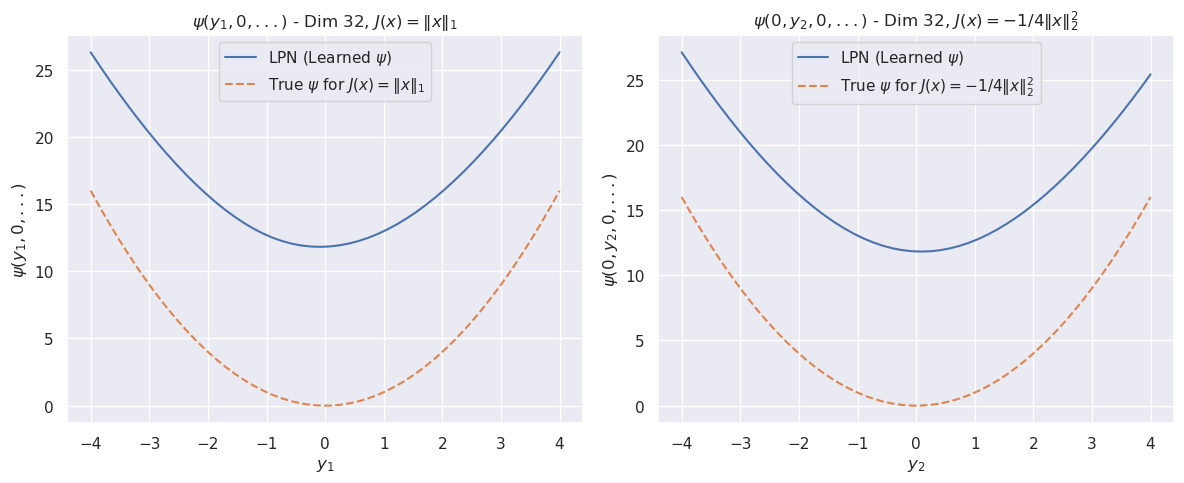

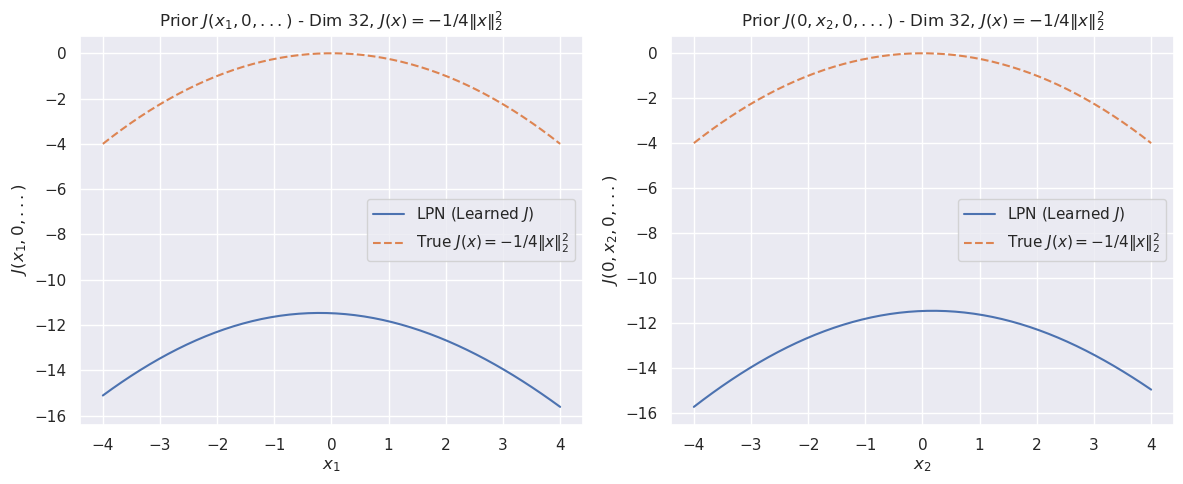

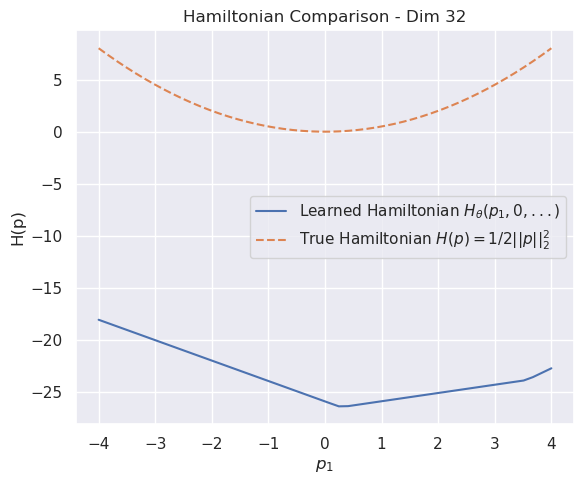

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27627.044921875
iteration 0 loss 21422.56640625


iteration 500 loss 386.03704833984375


iteration 1000 loss 321.0011291503906


iteration 1500 loss 280.2021179199219


iteration 2000 loss 257.38543701171875


iteration 2500 loss 245.12002563476562


iteration 3000 loss 236.90155029296875


iteration 3500 loss 229.1551971435547


iteration 4000 loss 220.70388793945312


iteration 4500 loss 211.3149871826172


iteration 5000 loss 200.71878051757812


iteration 5500 loss 188.56744384765625


iteration 6000 loss 174.4008026123047


iteration 6500 loss 156.5441436767578


iteration 7000 loss 129.51385498046875


iteration 7500 loss 80.4736328125


iteration 8000 loss 38.97367858886719


iteration 8500 loss 27.15338706970215


iteration 9000 loss 21.74776268005371


iteration 9500 loss 18.715499877929688


iteration 10000 loss 16.689844131469727


iteration 10500 loss 15.304238319396973


iteration 11000 loss 14.250665664672852


iteration 11500 loss 13.391423225402832


iteration 12000 loss 12.712309837341309


iteration 12500 loss 12.117093086242676


iteration 13000 loss 11.653815269470215


iteration 13500 loss 11.21802043914795


iteration 14000 loss 10.887081146240234


iteration 14500 loss 10.557380676269531


iteration 15000 loss 10.323111534118652


iteration 15500 loss 10.094372749328613


iteration 16000 loss 9.848276138305664


iteration 16500 loss 9.687154769897461


iteration 17000 loss 9.509442329406738


iteration 17500 loss 9.322224617004395


iteration 18000 loss 9.192465782165527


iteration 18500 loss 9.040812492370605


iteration 19000 loss 8.902410507202148


iteration 19500 loss 8.79305648803711


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 8.66366195678711


iteration 20500 loss 8.64834213256836


iteration 21000 loss 8.629276275634766


iteration 21500 loss 8.605674743652344


iteration 22000 loss 8.576861381530762


iteration 22500 loss 8.542093276977539


iteration 23000 loss 8.500274658203125


iteration 23500 loss 8.450721740722656


iteration 24000 loss 8.39376449584961


iteration 24500 loss 8.329202651977539


iteration 25000 loss 8.25769329071045


iteration 25500 loss 8.18603229522705


iteration 26000 loss 8.118722915649414


iteration 26500 loss 8.054311752319336


iteration 27000 loss 7.990977764129639


iteration 27500 loss 7.928343772888184


iteration 28000 loss 7.866940498352051


iteration 28500 loss 7.80809211730957


iteration 29000 loss 7.751059055328369


iteration 29500 loss 7.695230960845947


iteration 30000 loss 7.641632556915283


iteration 30500 loss 7.589390277862549


iteration 31000 loss 7.537997245788574


iteration 31500 loss 7.487162113189697


iteration 32000 loss 7.437191963195801


iteration 32500 loss 7.387663841247559


iteration 33000 loss 7.338977813720703


iteration 33500 loss 7.29163122177124


iteration 34000 loss 7.24549674987793


iteration 34500 loss 7.201014041900635


iteration 35000 loss 7.1574811935424805


iteration 35500 loss 7.114115238189697


iteration 36000 loss 7.071523189544678


iteration 36500 loss 7.029329299926758


iteration 37000 loss 6.9875922203063965


iteration 37500 loss 6.946187496185303


iteration 38000 loss 6.9045233726501465


iteration 38500 loss 6.862671852111816


iteration 39000 loss 6.820721626281738


iteration 39500 loss 6.77869987487793


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 6.736140251159668


iteration 40500 loss 6.731501579284668


iteration 41000 loss 6.726116180419922


iteration 41500 loss 6.7199859619140625


iteration 42000 loss 6.7131452560424805


iteration 42500 loss 6.705670356750488


iteration 43000 loss 6.697665691375732


iteration 43500 loss 6.689239025115967


iteration 44000 loss 6.680506229400635


iteration 44500 loss 6.671567916870117


iteration 45000 loss 6.662522315979004


iteration 45500 loss 6.653473377227783


iteration 46000 loss 6.644455909729004


iteration 46500 loss 6.635503768920898


iteration 47000 loss 6.6265997886657715


iteration 47500 loss 6.617727279663086


iteration 48000 loss 6.608871936798096


iteration 48500 loss 6.600018501281738


iteration 49000 loss 6.591165542602539


iteration 49500 loss 6.582303524017334


iteration 50000 loss 6.573424816131592


iteration 50500 loss 6.564527988433838


iteration 51000 loss 6.555592060089111


iteration 51500 loss 6.546630382537842


iteration 52000 loss 6.537623882293701


iteration 52500 loss 6.5285749435424805


iteration 53000 loss 6.519486427307129


iteration 53500 loss 6.5103583335876465


iteration 54000 loss 6.501190185546875


iteration 54500 loss 6.491980075836182


iteration 55000 loss 6.482728004455566


iteration 55500 loss 6.473423957824707


iteration 56000 loss 6.464077472686768


iteration 56500 loss 6.4546895027160645


iteration 57000 loss 6.445252418518066


iteration 57500 loss 6.435764789581299


iteration 58000 loss 6.426226615905762


iteration 58500 loss 6.416635990142822


iteration 59000 loss 6.406985759735107


iteration 59500 loss 6.397284030914307


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 6.3875203132629395


iteration 60500 loss 6.386542797088623


iteration 61000 loss 6.385550498962402


iteration 61500 loss 6.384547710418701


iteration 62000 loss 6.383540153503418


iteration 62500 loss 6.382525444030762


iteration 63000 loss 6.381509780883789


iteration 63500 loss 6.380495071411133


iteration 64000 loss 6.37947940826416


iteration 64500 loss 6.378464698791504


iteration 65000 loss 6.377452373504639


iteration 65500 loss 6.376440048217773


iteration 66000 loss 6.375430107116699


iteration 66500 loss 6.3744215965271


iteration 67000 loss 6.373414039611816


iteration 67500 loss 6.372405529022217


iteration 68000 loss 6.371399402618408


iteration 68500 loss 6.3703932762146


iteration 69000 loss 6.369388580322266


iteration 69500 loss 6.368383407592773


iteration 70000 loss 6.367380142211914


iteration 70500 loss 6.36637544631958


iteration 71000 loss 6.365370750427246


iteration 71500 loss 6.3643670082092285


iteration 72000 loss 6.363363265991211


iteration 72500 loss 6.362358093261719


iteration 73000 loss 6.361354351043701


iteration 73500 loss 6.360349655151367


iteration 74000 loss 6.359344959259033


iteration 74500 loss 6.358340263366699


iteration 75000 loss 6.357335567474365


iteration 75500 loss 6.356330871582031


iteration 76000 loss 6.355326175689697


iteration 76500 loss 6.354321002960205


iteration 77000 loss 6.3533148765563965


iteration 77500 loss 6.352309703826904


iteration 78000 loss 6.351303577423096


iteration 78500 loss 6.350296974182129


iteration 79000 loss 6.349289894104004


iteration 79500 loss 6.348282814025879


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 6.347275733947754


iteration 80500 loss 6.3471856117248535


iteration 81000 loss 6.347095012664795


iteration 81500 loss 6.347004413604736


iteration 82000 loss 6.346914768218994


iteration 82500 loss 6.346824645996094


iteration 83000 loss 6.346733570098877


iteration 83500 loss 6.346643447875977


iteration 84000 loss 6.346553325653076


iteration 84500 loss 6.346463680267334


iteration 85000 loss 6.346372604370117


iteration 85500 loss 6.346282958984375


iteration 86000 loss 6.346192836761475


iteration 86500 loss 6.346102714538574


iteration 87000 loss 6.346013069152832


iteration 87500 loss 6.345922470092773


iteration 88000 loss 6.345832824707031


iteration 88500 loss 6.345742225646973


iteration 89000 loss 6.345653057098389


iteration 89500 loss 6.345562934875488


iteration 90000 loss 6.345472812652588


iteration 90500 loss 6.345383644104004


iteration 91000 loss 6.345292568206787


iteration 91500 loss 6.345202922821045


iteration 92000 loss 6.345113277435303


iteration 92500 loss 6.345023155212402


iteration 93000 loss 6.34493350982666


iteration 93500 loss 6.344842910766602


iteration 94000 loss 6.344753742218018


iteration 94500 loss 6.344664096832275


iteration 95000 loss 6.344573974609375


iteration 95500 loss 6.344484329223633


iteration 96000 loss 6.344394207000732


iteration 96500 loss 6.34430456161499


iteration 97000 loss 6.344214916229248


iteration 97500 loss 6.344124794006348


iteration 98000 loss 6.344035625457764


iteration 98500 loss 6.343945026397705


iteration 99000 loss 6.343855381011963


iteration 99500 loss 6.3437652587890625


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 6.34367561340332


iteration 100500 loss 6.343674659729004


iteration 101000 loss 6.343673229217529


iteration 101500 loss 6.343671798706055


iteration 102000 loss 6.34367036819458


iteration 102500 loss 6.34367036819458


iteration 103000 loss 6.3436689376831055


iteration 103500 loss 6.343667507171631


iteration 104000 loss 6.343666076660156


iteration 104500 loss 6.343664646148682


iteration 105000 loss 6.343663692474365


iteration 105500 loss 6.343662261962891


iteration 106000 loss 6.343661785125732


iteration 106500 loss 6.3436598777771


iteration 107000 loss 6.343659400939941


iteration 107500 loss 6.343657970428467


iteration 108000 loss 6.34365701675415


iteration 108500 loss 6.343655586242676


iteration 109000 loss 6.343654155731201


iteration 109500 loss 6.343653202056885


iteration 110000 loss 6.343652725219727


iteration 110500 loss 6.343650817871094


iteration 111000 loss 6.343649387359619


iteration 111500 loss 6.343648433685303


iteration 112000 loss 6.34364652633667


iteration 112500 loss 6.343646049499512


iteration 113000 loss 6.343645095825195


iteration 113500 loss 6.343643665313721


iteration 114000 loss 6.343642711639404


iteration 114500 loss 6.34364128112793


iteration 115000 loss 6.343639850616455


iteration 115500 loss 6.343639373779297


iteration 116000 loss 6.343637943267822


iteration 116500 loss 6.343636512756348


iteration 117000 loss 6.343635559082031


iteration 117500 loss 6.343633651733398


iteration 118000 loss 6.343632698059082


iteration 118500 loss 6.343631744384766


iteration 119000 loss 6.343630790710449


iteration 119500 loss 6.343629360198975


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 6.343628883361816


iteration 120500 loss 6.343628406524658


iteration 121000 loss 6.343628883361816


iteration 121500 loss 6.343628406524658


iteration 122000 loss 6.343628406524658


iteration 122500 loss 6.343628883361816


iteration 123000 loss 6.343628406524658


iteration 123500 loss 6.343628406524658


iteration 124000 loss 6.343628406524658


iteration 124500 loss 6.343628406524658


iteration 125000 loss 6.343628883361816


iteration 125500 loss 6.343628883361816


iteration 126000 loss 6.343628406524658


iteration 126500 loss 6.3436279296875


iteration 127000 loss 6.343628406524658


iteration 127500 loss 6.343628406524658


iteration 128000 loss 6.3436279296875


iteration 128500 loss 6.3436279296875


iteration 129000 loss 6.343628883361816


iteration 129500 loss 6.343628406524658


iteration 130000 loss 6.343628406524658


iteration 130500 loss 6.343628406524658


iteration 131000 loss 6.343628406524658


iteration 131500 loss 6.3436279296875


iteration 132000 loss 6.3436279296875


iteration 132500 loss 6.3436279296875


iteration 133000 loss 6.3436279296875


iteration 133500 loss 6.3436279296875


iteration 134000 loss 6.3436279296875


iteration 134500 loss 6.343628406524658


iteration 135000 loss 6.3436279296875


iteration 135500 loss 6.343628406524658


iteration 136000 loss 6.343628406524658


iteration 136500 loss 6.343628406524658


iteration 137000 loss 6.3436279296875


iteration 137500 loss 6.3436279296875


iteration 138000 loss 6.3436279296875


iteration 138500 loss 6.3436279296875


iteration 139000 loss 6.343628406524658


iteration 139500 loss 6.343628406524658


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 6.3436279296875


iteration 140500 loss 6.343628406524658


iteration 141000 loss 6.343628406524658


iteration 141500 loss 6.3436279296875


iteration 142000 loss 6.343628406524658


iteration 142500 loss 6.3436279296875


iteration 143000 loss 6.343628406524658


iteration 143500 loss 6.3436279296875


iteration 144000 loss 6.343628406524658


iteration 144500 loss 6.3436279296875


iteration 145000 loss 6.3436279296875


iteration 145500 loss 6.3436279296875


iteration 146000 loss 6.3436279296875


iteration 146500 loss 6.3436279296875


iteration 147000 loss 6.3436279296875


iteration 147500 loss 6.3436279296875


iteration 148000 loss 6.3436279296875


iteration 148500 loss 6.343628406524658


iteration 149000 loss 6.343628406524658


iteration 149500 loss 6.3436279296875


iteration 150000 loss 6.343628406524658


iteration 150500 loss 6.343628406524658


iteration 151000 loss 6.343628406524658


iteration 151500 loss 6.343628406524658


iteration 152000 loss 6.3436279296875


iteration 152500 loss 6.3436279296875


iteration 153000 loss 6.3436279296875


iteration 153500 loss 6.3436279296875


iteration 154000 loss 6.3436279296875


iteration 154500 loss 6.3436279296875


iteration 155000 loss 6.3436279296875


iteration 155500 loss 6.3436279296875


iteration 156000 loss 6.343628406524658


iteration 156500 loss 6.3436279296875


iteration 157000 loss 6.3436279296875


iteration 157500 loss 6.3436279296875


iteration 158000 loss 6.3436279296875


iteration 158500 loss 6.3436279296875


iteration 159000 loss 6.3436279296875


iteration 159500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 6.3436279296875


iteration 160500 loss 6.3436279296875


iteration 161000 loss 6.3436279296875


iteration 161500 loss 6.3436279296875


iteration 162000 loss 6.3436279296875


iteration 162500 loss 6.3436279296875


iteration 163000 loss 6.3436279296875


iteration 163500 loss 6.3436279296875


iteration 164000 loss 6.3436279296875


iteration 164500 loss 6.3436279296875


iteration 165000 loss 6.3436279296875


iteration 165500 loss 6.3436279296875


iteration 166000 loss 6.3436279296875


iteration 166500 loss 6.3436279296875


iteration 167000 loss 6.3436279296875


iteration 167500 loss 6.3436279296875


iteration 168000 loss 6.3436279296875


iteration 168500 loss 6.3436279296875


iteration 169000 loss 6.3436279296875


iteration 169500 loss 6.3436279296875


iteration 170000 loss 6.3436279296875


iteration 170500 loss 6.3436279296875


iteration 171000 loss 6.3436279296875


iteration 171500 loss 6.3436279296875


iteration 172000 loss 6.3436279296875


iteration 172500 loss 6.3436279296875


iteration 173000 loss 6.3436279296875


iteration 173500 loss 6.3436279296875


iteration 174000 loss 6.3436279296875


iteration 174500 loss 6.3436279296875


iteration 175000 loss 6.3436279296875


iteration 175500 loss 6.3436279296875


iteration 176000 loss 6.3436279296875


iteration 176500 loss 6.3436279296875


iteration 177000 loss 6.3436279296875


iteration 177500 loss 6.3436279296875


iteration 178000 loss 6.3436279296875


iteration 178500 loss 6.3436279296875


iteration 179000 loss 6.3436279296875


iteration 179500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 6.3436279296875


iteration 180500 loss 6.3436279296875


iteration 181000 loss 6.3436279296875


iteration 181500 loss 6.3436279296875


iteration 182000 loss 6.3436279296875


iteration 182500 loss 6.3436279296875


iteration 183000 loss 6.3436279296875


iteration 183500 loss 6.3436279296875


iteration 184000 loss 6.3436279296875


iteration 184500 loss 6.3436279296875


iteration 185000 loss 6.3436279296875


iteration 185500 loss 6.3436279296875


iteration 186000 loss 6.3436279296875


iteration 186500 loss 6.3436279296875


iteration 187000 loss 6.3436279296875


iteration 187500 loss 6.3436279296875


iteration 188000 loss 6.3436279296875


iteration 188500 loss 6.3436279296875


iteration 189000 loss 6.3436279296875


iteration 189500 loss 6.3436279296875


iteration 190000 loss 6.3436279296875


iteration 190500 loss 6.3436279296875


iteration 191000 loss 6.3436279296875


iteration 191500 loss 6.3436279296875


iteration 192000 loss 6.3436279296875


iteration 192500 loss 6.3436279296875


iteration 193000 loss 6.3436279296875


iteration 193500 loss 6.3436279296875


iteration 194000 loss 6.3436279296875


iteration 194500 loss 6.3436279296875


iteration 195000 loss 6.3436279296875


iteration 195500 loss 6.3436279296875


iteration 196000 loss 6.3436279296875


iteration 196500 loss 6.3436279296875


iteration 197000 loss 6.3436279296875


iteration 197500 loss 6.3436279296875


iteration 198000 loss 6.3436279296875


iteration 198500 loss 6.3436279296875


iteration 199000 loss 6.3436279296875


iteration 199500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 6.3436279296875


iteration 200500 loss 6.3436279296875


iteration 201000 loss 6.3436279296875


iteration 201500 loss 6.3436279296875


iteration 202000 loss 6.3436279296875


iteration 202500 loss 6.3436279296875


iteration 203000 loss 6.3436279296875


iteration 203500 loss 6.3436279296875


iteration 204000 loss 6.3436279296875


iteration 204500 loss 6.3436279296875


iteration 205000 loss 6.3436279296875


iteration 205500 loss 6.3436279296875


iteration 206000 loss 6.3436279296875


iteration 206500 loss 6.3436279296875


iteration 207000 loss 6.3436279296875


iteration 207500 loss 6.3436279296875


iteration 208000 loss 6.3436279296875


iteration 208500 loss 6.3436279296875


iteration 209000 loss 6.3436279296875


iteration 209500 loss 6.3436279296875


iteration 210000 loss 6.3436279296875


iteration 210500 loss 6.3436279296875


iteration 211000 loss 6.3436279296875


iteration 211500 loss 6.3436279296875


iteration 212000 loss 6.3436279296875


iteration 212500 loss 6.3436279296875


iteration 213000 loss 6.3436279296875


iteration 213500 loss 6.3436279296875


iteration 214000 loss 6.3436279296875


iteration 214500 loss 6.3436279296875


iteration 215000 loss 6.3436279296875


iteration 215500 loss 6.3436279296875


iteration 216000 loss 6.3436279296875


iteration 216500 loss 6.3436279296875


iteration 217000 loss 6.3436279296875


iteration 217500 loss 6.3436279296875


iteration 218000 loss 6.3436279296875


iteration 218500 loss 6.3436279296875


iteration 219000 loss 6.3436279296875


iteration 219500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 6.3436279296875


iteration 220500 loss 6.3436279296875


iteration 221000 loss 6.3436279296875


iteration 221500 loss 6.3436279296875


iteration 222000 loss 6.3436279296875


iteration 222500 loss 6.3436279296875


iteration 223000 loss 6.3436279296875


iteration 223500 loss 6.3436279296875


iteration 224000 loss 6.3436279296875


iteration 224500 loss 6.3436279296875


iteration 225000 loss 6.3436279296875


iteration 225500 loss 6.3436279296875


iteration 226000 loss 6.3436279296875


iteration 226500 loss 6.3436279296875


iteration 227000 loss 6.3436279296875


iteration 227500 loss 6.3436279296875


iteration 228000 loss 6.3436279296875


iteration 228500 loss 6.3436279296875


iteration 229000 loss 6.3436279296875


iteration 229500 loss 6.3436279296875


iteration 230000 loss 6.3436279296875


iteration 230500 loss 6.3436279296875


iteration 231000 loss 6.3436279296875


iteration 231500 loss 6.3436279296875


iteration 232000 loss 6.3436279296875


iteration 232500 loss 6.3436279296875


iteration 233000 loss 6.3436279296875


iteration 233500 loss 6.3436279296875


iteration 234000 loss 6.3436279296875


iteration 234500 loss 6.3436279296875


iteration 235000 loss 6.3436279296875


iteration 235500 loss 6.3436279296875


iteration 236000 loss 6.3436279296875


iteration 236500 loss 6.3436279296875


iteration 237000 loss 6.3436279296875


iteration 237500 loss 6.3436279296875


iteration 238000 loss 6.3436279296875


iteration 238500 loss 6.3436279296875


iteration 239000 loss 6.3436279296875


iteration 239500 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 6.3436279296875


iteration 240500 loss 6.3436279296875


iteration 241000 loss 6.3436279296875


iteration 241500 loss 6.3436279296875


iteration 242000 loss 6.3436279296875


iteration 242500 loss 6.3436279296875


iteration 243000 loss 6.3436279296875


iteration 243500 loss 6.3436279296875


iteration 244000 loss 6.3436279296875


iteration 244500 loss 6.3436279296875


iteration 245000 loss 6.3436279296875


iteration 245500 loss 6.3436279296875


iteration 246000 loss 6.3436279296875


iteration 246500 loss 6.3436279296875


iteration 247000 loss 6.3436279296875


iteration 247500 loss 6.3436279296875


iteration 248000 loss 6.3436279296875


iteration 248500 loss 6.3436279296875


iteration 249000 loss 6.3436279296875


iteration 249500 loss 6.3436279296875


iteration 250000 loss 6.3436279296875


iteration 250500 loss 6.3436279296875


iteration 251000 loss 6.3436279296875


iteration 251500 loss 6.3436279296875


iteration 252000 loss 6.3436279296875


iteration 252500 loss 6.3436279296875


iteration 253000 loss 6.3436279296875


iteration 253500 loss 6.3436279296875


iteration 254000 loss 6.3436279296875


iteration 254500 loss 6.3436279296875


iteration 255000 loss 6.3436279296875


iteration 255500 loss 6.3436279296875


iteration 256000 loss 6.3436279296875


iteration 256500 loss 6.3436279296875


iteration 257000 loss 6.3436279296875


iteration 257500 loss 6.3436279296875


iteration 258000 loss 6.3436279296875


iteration 258500 loss 6.3436279296875


iteration 259000 loss 6.3436279296875


iteration 259500 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 6.3436279296875


iteration 260500 loss 6.3436279296875


iteration 261000 loss 6.3436279296875


iteration 261500 loss 6.3436279296875


iteration 262000 loss 6.3436279296875


iteration 262500 loss 6.3436279296875


iteration 263000 loss 6.3436279296875


iteration 263500 loss 6.3436279296875


iteration 264000 loss 6.3436279296875


iteration 264500 loss 6.3436279296875


iteration 265000 loss 6.3436279296875


iteration 265500 loss 6.3436279296875


iteration 266000 loss 6.3436279296875


iteration 266500 loss 6.3436279296875


iteration 267000 loss 6.3436279296875


iteration 267500 loss 6.3436279296875


iteration 268000 loss 6.3436279296875


iteration 268500 loss 6.3436279296875


iteration 269000 loss 6.3436279296875


iteration 269500 loss 6.3436279296875


iteration 270000 loss 6.3436279296875


iteration 270500 loss 6.3436279296875


iteration 271000 loss 6.3436279296875


iteration 271500 loss 6.3436279296875


iteration 272000 loss 6.3436279296875


iteration 272500 loss 6.3436279296875


iteration 273000 loss 6.3436279296875


iteration 273500 loss 6.3436279296875


iteration 274000 loss 6.3436279296875


iteration 274500 loss 6.3436279296875


iteration 275000 loss 6.3436279296875


iteration 275500 loss 6.3436279296875


iteration 276000 loss 6.3436279296875


iteration 276500 loss 6.3436279296875


iteration 277000 loss 6.3436279296875


iteration 277500 loss 6.3436279296875


iteration 278000 loss 6.3436279296875


iteration 278500 loss 6.3436279296875


iteration 279000 loss 6.3436279296875


iteration 279500 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 6.3436279296875


iteration 280500 loss 6.3436279296875


iteration 281000 loss 6.3436279296875


iteration 281500 loss 6.3436279296875


iteration 282000 loss 6.3436279296875


iteration 282500 loss 6.3436279296875


iteration 283000 loss 6.3436279296875


iteration 283500 loss 6.3436279296875


iteration 284000 loss 6.3436279296875


iteration 284500 loss 6.3436279296875


iteration 285000 loss 6.3436279296875


iteration 285500 loss 6.3436279296875


iteration 286000 loss 6.3436279296875


iteration 286500 loss 6.3436279296875


iteration 287000 loss 6.3436279296875


iteration 287500 loss 6.3436279296875


iteration 288000 loss 6.3436279296875


iteration 288500 loss 6.3436279296875


iteration 289000 loss 6.3436279296875


iteration 289500 loss 6.3436279296875


iteration 290000 loss 6.3436279296875


iteration 290500 loss 6.3436279296875


iteration 291000 loss 6.3436279296875


iteration 291500 loss 6.3436279296875


iteration 292000 loss 6.3436279296875


iteration 292500 loss 6.3436279296875


iteration 293000 loss 6.3436279296875


iteration 293500 loss 6.3436279296875


iteration 294000 loss 6.3436279296875


iteration 294500 loss 6.3436279296875


iteration 295000 loss 6.3436279296875


iteration 295500 loss 6.3436279296875


iteration 296000 loss 6.3436279296875


iteration 296500 loss 6.3436279296875


iteration 297000 loss 6.3436279296875


iteration 297500 loss 6.3436279296875


iteration 298000 loss 6.3436279296875


iteration 298500 loss 6.3436279296875


iteration 299000 loss 6.3436279296875


iteration 299500 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 6.3436279296875


iteration 300500 loss 6.3436279296875


iteration 301000 loss 6.3436279296875


iteration 301500 loss 6.3436279296875


iteration 302000 loss 6.3436279296875


iteration 302500 loss 6.3436279296875


iteration 303000 loss 6.3436279296875


iteration 303500 loss 6.3436279296875


iteration 304000 loss 6.3436279296875


iteration 304500 loss 6.3436279296875


iteration 305000 loss 6.3436279296875


iteration 305500 loss 6.3436279296875


iteration 306000 loss 6.3436279296875


iteration 306500 loss 6.3436279296875


iteration 307000 loss 6.3436279296875


iteration 307500 loss 6.3436279296875


iteration 308000 loss 6.3436279296875


iteration 308500 loss 6.3436279296875


iteration 309000 loss 6.3436279296875


iteration 309500 loss 6.3436279296875


iteration 310000 loss 6.3436279296875


iteration 310500 loss 6.3436279296875


iteration 311000 loss 6.3436279296875


iteration 311500 loss 6.3436279296875


iteration 312000 loss 6.3436279296875


iteration 312500 loss 6.3436279296875


iteration 313000 loss 6.3436279296875


iteration 313500 loss 6.3436279296875


iteration 314000 loss 6.3436279296875


iteration 314500 loss 6.3436279296875


iteration 315000 loss 6.3436279296875


iteration 315500 loss 6.3436279296875


iteration 316000 loss 6.3436279296875


iteration 316500 loss 6.3436279296875


iteration 317000 loss 6.3436279296875


iteration 317500 loss 6.3436279296875


iteration 318000 loss 6.3436279296875


iteration 318500 loss 6.3436279296875


iteration 319000 loss 6.3436279296875


iteration 319500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 6.3436279296875


iteration 320500 loss 6.3436279296875


iteration 321000 loss 6.3436279296875


iteration 321500 loss 6.3436279296875


iteration 322000 loss 6.3436279296875


iteration 322500 loss 6.3436279296875


iteration 323000 loss 6.3436279296875


iteration 323500 loss 6.3436279296875


iteration 324000 loss 6.3436279296875


iteration 324500 loss 6.3436279296875


iteration 325000 loss 6.3436279296875


iteration 325500 loss 6.3436279296875


iteration 326000 loss 6.3436279296875


iteration 326500 loss 6.3436279296875


iteration 327000 loss 6.3436279296875


iteration 327500 loss 6.3436279296875


iteration 328000 loss 6.3436279296875


iteration 328500 loss 6.3436279296875


iteration 329000 loss 6.3436279296875


iteration 329500 loss 6.3436279296875


iteration 330000 loss 6.3436279296875


iteration 330500 loss 6.3436279296875


iteration 331000 loss 6.3436279296875


iteration 331500 loss 6.3436279296875


iteration 332000 loss 6.3436279296875


iteration 332500 loss 6.3436279296875


iteration 333000 loss 6.3436279296875


iteration 333500 loss 6.3436279296875


iteration 334000 loss 6.3436279296875


iteration 334500 loss 6.3436279296875


iteration 335000 loss 6.3436279296875


iteration 335500 loss 6.3436279296875


iteration 336000 loss 6.3436279296875


iteration 336500 loss 6.3436279296875


iteration 337000 loss 6.3436279296875


iteration 337500 loss 6.3436279296875


iteration 338000 loss 6.3436279296875


iteration 338500 loss 6.3436279296875


iteration 339000 loss 6.3436279296875


iteration 339500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 6.3436279296875


iteration 340500 loss 6.3436279296875


iteration 341000 loss 6.3436279296875


iteration 341500 loss 6.3436279296875


iteration 342000 loss 6.3436279296875


iteration 342500 loss 6.3436279296875


iteration 343000 loss 6.3436279296875


iteration 343500 loss 6.3436279296875


iteration 344000 loss 6.3436279296875


iteration 344500 loss 6.3436279296875


iteration 345000 loss 6.3436279296875


iteration 345500 loss 6.3436279296875


iteration 346000 loss 6.3436279296875


iteration 346500 loss 6.3436279296875


iteration 347000 loss 6.3436279296875


iteration 347500 loss 6.3436279296875


iteration 348000 loss 6.3436279296875


iteration 348500 loss 6.3436279296875


iteration 349000 loss 6.3436279296875


iteration 349500 loss 6.3436279296875


iteration 350000 loss 6.3436279296875


iteration 350500 loss 6.3436279296875


iteration 351000 loss 6.3436279296875


iteration 351500 loss 6.3436279296875


iteration 352000 loss 6.3436279296875


iteration 352500 loss 6.3436279296875


iteration 353000 loss 6.3436279296875


iteration 353500 loss 6.3436279296875


iteration 354000 loss 6.3436279296875


iteration 354500 loss 6.3436279296875


iteration 355000 loss 6.3436279296875


iteration 355500 loss 6.3436279296875


iteration 356000 loss 6.3436279296875


iteration 356500 loss 6.3436279296875


iteration 357000 loss 6.3436279296875


iteration 357500 loss 6.3436279296875


iteration 358000 loss 6.3436279296875


iteration 358500 loss 6.3436279296875


iteration 359000 loss 6.3436279296875


iteration 359500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 6.3436279296875


iteration 360500 loss 6.3436279296875


iteration 361000 loss 6.3436279296875


iteration 361500 loss 6.3436279296875


iteration 362000 loss 6.3436279296875


iteration 362500 loss 6.3436279296875


iteration 363000 loss 6.3436279296875


iteration 363500 loss 6.3436279296875


iteration 364000 loss 6.3436279296875


iteration 364500 loss 6.3436279296875


iteration 365000 loss 6.3436279296875


iteration 365500 loss 6.3436279296875


iteration 366000 loss 6.3436279296875


iteration 366500 loss 6.3436279296875


iteration 367000 loss 6.3436279296875


iteration 367500 loss 6.3436279296875


iteration 368000 loss 6.3436279296875


iteration 368500 loss 6.3436279296875


iteration 369000 loss 6.3436279296875


iteration 369500 loss 6.3436279296875


iteration 370000 loss 6.3436279296875


iteration 370500 loss 6.3436279296875


iteration 371000 loss 6.3436279296875


iteration 371500 loss 6.3436279296875


iteration 372000 loss 6.3436279296875


iteration 372500 loss 6.3436279296875


iteration 373000 loss 6.3436279296875


iteration 373500 loss 6.3436279296875


iteration 374000 loss 6.3436279296875


iteration 374500 loss 6.3436279296875


iteration 375000 loss 6.3436279296875


iteration 375500 loss 6.3436279296875


iteration 376000 loss 6.3436279296875


iteration 376500 loss 6.3436279296875


iteration 377000 loss 6.3436279296875


iteration 377500 loss 6.3436279296875


iteration 378000 loss 6.3436279296875


iteration 378500 loss 6.3436279296875


iteration 379000 loss 6.3436279296875


iteration 379500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 6.3436279296875


iteration 380500 loss 6.3436279296875


iteration 381000 loss 6.3436279296875


iteration 381500 loss 6.3436279296875


iteration 382000 loss 6.3436279296875


iteration 382500 loss 6.3436279296875


iteration 383000 loss 6.3436279296875


iteration 383500 loss 6.3436279296875


iteration 384000 loss 6.3436279296875


iteration 384500 loss 6.3436279296875


iteration 385000 loss 6.3436279296875


iteration 385500 loss 6.3436279296875


iteration 386000 loss 6.3436279296875


iteration 386500 loss 6.3436279296875


iteration 387000 loss 6.3436279296875


iteration 387500 loss 6.3436279296875


iteration 388000 loss 6.3436279296875


iteration 388500 loss 6.3436279296875


iteration 389000 loss 6.3436279296875


iteration 389500 loss 6.3436279296875


iteration 390000 loss 6.3436279296875


iteration 390500 loss 6.3436279296875


iteration 391000 loss 6.3436279296875


iteration 391500 loss 6.3436279296875


iteration 392000 loss 6.3436279296875


iteration 392500 loss 6.3436279296875


iteration 393000 loss 6.3436279296875


iteration 393500 loss 6.3436279296875


iteration 394000 loss 6.3436279296875


iteration 394500 loss 6.3436279296875


iteration 395000 loss 6.3436279296875


iteration 395500 loss 6.3436279296875


iteration 396000 loss 6.3436279296875


iteration 396500 loss 6.3436279296875


iteration 397000 loss 6.3436279296875


iteration 397500 loss 6.3436279296875


iteration 398000 loss 6.3436279296875


iteration 398500 loss 6.3436279296875


iteration 399000 loss 6.3436279296875


iteration 399500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 6.3436279296875


iteration 400500 loss 6.3436279296875


iteration 401000 loss 6.3436279296875


iteration 401500 loss 6.3436279296875


iteration 402000 loss 6.3436279296875


iteration 402500 loss 6.3436279296875


iteration 403000 loss 6.3436279296875


iteration 403500 loss 6.3436279296875


iteration 404000 loss 6.3436279296875


iteration 404500 loss 6.3436279296875


iteration 405000 loss 6.3436279296875


iteration 405500 loss 6.3436279296875


iteration 406000 loss 6.3436279296875


iteration 406500 loss 6.3436279296875


iteration 407000 loss 6.3436279296875


iteration 407500 loss 6.3436279296875


iteration 408000 loss 6.3436279296875


iteration 408500 loss 6.3436279296875


iteration 409000 loss 6.3436279296875


iteration 409500 loss 6.3436279296875


iteration 410000 loss 6.3436279296875


iteration 410500 loss 6.3436279296875


iteration 411000 loss 6.3436279296875


iteration 411500 loss 6.3436279296875


iteration 412000 loss 6.3436279296875


iteration 412500 loss 6.3436279296875


iteration 413000 loss 6.3436279296875


iteration 413500 loss 6.3436279296875


iteration 414000 loss 6.3436279296875


iteration 414500 loss 6.3436279296875


iteration 415000 loss 6.3436279296875


iteration 415500 loss 6.3436279296875


iteration 416000 loss 6.3436279296875


iteration 416500 loss 6.3436279296875


iteration 417000 loss 6.3436279296875


iteration 417500 loss 6.3436279296875


iteration 418000 loss 6.3436279296875


iteration 418500 loss 6.3436279296875


iteration 419000 loss 6.3436279296875


iteration 419500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 6.3436279296875


iteration 420500 loss 6.3436279296875


iteration 421000 loss 6.3436279296875


iteration 421500 loss 6.3436279296875


iteration 422000 loss 6.3436279296875


iteration 422500 loss 6.3436279296875


iteration 423000 loss 6.3436279296875


iteration 423500 loss 6.3436279296875


iteration 424000 loss 6.3436279296875


iteration 424500 loss 6.3436279296875


iteration 425000 loss 6.3436279296875


iteration 425500 loss 6.3436279296875


iteration 426000 loss 6.3436279296875


iteration 426500 loss 6.3436279296875


iteration 427000 loss 6.3436279296875


iteration 427500 loss 6.3436279296875


iteration 428000 loss 6.3436279296875


iteration 428500 loss 6.3436279296875


iteration 429000 loss 6.3436279296875


iteration 429500 loss 6.3436279296875


iteration 430000 loss 6.3436279296875


iteration 430500 loss 6.3436279296875


iteration 431000 loss 6.3436279296875


iteration 431500 loss 6.3436279296875


iteration 432000 loss 6.3436279296875


iteration 432500 loss 6.3436279296875


iteration 433000 loss 6.3436279296875


iteration 433500 loss 6.3436279296875


iteration 434000 loss 6.3436279296875


iteration 434500 loss 6.3436279296875


iteration 435000 loss 6.3436279296875


iteration 435500 loss 6.3436279296875


iteration 436000 loss 6.3436279296875


iteration 436500 loss 6.3436279296875


iteration 437000 loss 6.3436279296875


iteration 437500 loss 6.3436279296875


iteration 438000 loss 6.3436279296875


iteration 438500 loss 6.3436279296875


iteration 439000 loss 6.3436279296875


iteration 439500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 6.3436279296875


iteration 440500 loss 6.3436279296875


iteration 441000 loss 6.3436279296875


iteration 441500 loss 6.3436279296875


iteration 442000 loss 6.3436279296875


iteration 442500 loss 6.3436279296875


iteration 443000 loss 6.3436279296875


iteration 443500 loss 6.3436279296875


iteration 444000 loss 6.3436279296875


iteration 444500 loss 6.3436279296875


iteration 445000 loss 6.3436279296875


iteration 445500 loss 6.3436279296875


iteration 446000 loss 6.3436279296875


iteration 446500 loss 6.3436279296875


iteration 447000 loss 6.3436279296875


iteration 447500 loss 6.3436279296875


iteration 448000 loss 6.3436279296875


iteration 448500 loss 6.3436279296875


iteration 449000 loss 6.3436279296875


iteration 449500 loss 6.3436279296875


iteration 450000 loss 6.3436279296875


iteration 450500 loss 6.3436279296875


iteration 451000 loss 6.3436279296875


iteration 451500 loss 6.3436279296875


iteration 452000 loss 6.3436279296875


iteration 452500 loss 6.3436279296875


iteration 453000 loss 6.3436279296875


iteration 453500 loss 6.3436279296875


iteration 454000 loss 6.3436279296875


iteration 454500 loss 6.3436279296875


iteration 455000 loss 6.3436279296875


iteration 455500 loss 6.3436279296875


iteration 456000 loss 6.3436279296875


iteration 456500 loss 6.3436279296875


iteration 457000 loss 6.3436279296875


iteration 457500 loss 6.3436279296875


iteration 458000 loss 6.3436279296875


iteration 458500 loss 6.3436279296875


iteration 459000 loss 6.3436279296875


iteration 459500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 6.3436279296875


iteration 460500 loss 6.3436279296875


iteration 461000 loss 6.3436279296875


iteration 461500 loss 6.3436279296875


iteration 462000 loss 6.3436279296875


iteration 462500 loss 6.3436279296875


iteration 463000 loss 6.3436279296875


iteration 463500 loss 6.3436279296875


iteration 464000 loss 6.3436279296875


iteration 464500 loss 6.3436279296875


iteration 465000 loss 6.3436279296875


iteration 465500 loss 6.3436279296875


iteration 466000 loss 6.3436279296875


iteration 466500 loss 6.3436279296875


iteration 467000 loss 6.3436279296875


iteration 467500 loss 6.3436279296875


iteration 468000 loss 6.3436279296875


iteration 468500 loss 6.3436279296875


iteration 469000 loss 6.3436279296875


iteration 469500 loss 6.3436279296875


iteration 470000 loss 6.3436279296875


iteration 470500 loss 6.3436279296875


iteration 471000 loss 6.3436279296875


iteration 471500 loss 6.3436279296875


iteration 472000 loss 6.3436279296875


iteration 472500 loss 6.3436279296875


iteration 473000 loss 6.3436279296875


iteration 473500 loss 6.3436279296875


iteration 474000 loss 6.3436279296875


iteration 474500 loss 6.3436279296875


iteration 475000 loss 6.3436279296875


iteration 475500 loss 6.3436279296875


iteration 476000 loss 6.3436279296875


iteration 476500 loss 6.3436279296875


iteration 477000 loss 6.3436279296875


iteration 477500 loss 6.3436279296875


iteration 478000 loss 6.3436279296875


iteration 478500 loss 6.3436279296875


iteration 479000 loss 6.3436279296875


iteration 479500 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 6.3436279296875


iteration 480500 loss 6.3436279296875


iteration 481000 loss 6.3436279296875


iteration 481500 loss 6.3436279296875


iteration 482000 loss 6.3436279296875


iteration 482500 loss 6.3436279296875


iteration 483000 loss 6.3436279296875


iteration 483500 loss 6.3436279296875


iteration 484000 loss 6.3436279296875


iteration 484500 loss 6.3436279296875


iteration 485000 loss 6.3436279296875


iteration 485500 loss 6.3436279296875


iteration 486000 loss 6.3436279296875


iteration 486500 loss 6.3436279296875


iteration 487000 loss 6.3436279296875


iteration 487500 loss 6.3436279296875


iteration 488000 loss 6.3436279296875


iteration 488500 loss 6.3436279296875


iteration 489000 loss 6.3436279296875


iteration 489500 loss 6.3436279296875


iteration 490000 loss 6.3436279296875


iteration 490500 loss 6.3436279296875


iteration 491000 loss 6.3436279296875


iteration 491500 loss 6.3436279296875


iteration 492000 loss 6.3436279296875


iteration 492500 loss 6.3436279296875


iteration 493000 loss 6.3436279296875


iteration 493500 loss 6.3436279296875


iteration 494000 loss 6.3436279296875


iteration 494500 loss 6.3436279296875


iteration 495000 loss 6.3436279296875


iteration 495500 loss 6.3436279296875


iteration 496000 loss 6.3436279296875


iteration 496500 loss 6.3436279296875


iteration 497000 loss 6.3436279296875


iteration 497500 loss 6.3436279296875


iteration 498000 loss 6.3436279296875


iteration 498500 loss 6.3436279296875


iteration 499000 loss 6.3436279296875


iteration 499500 loss 6.3436279296875


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


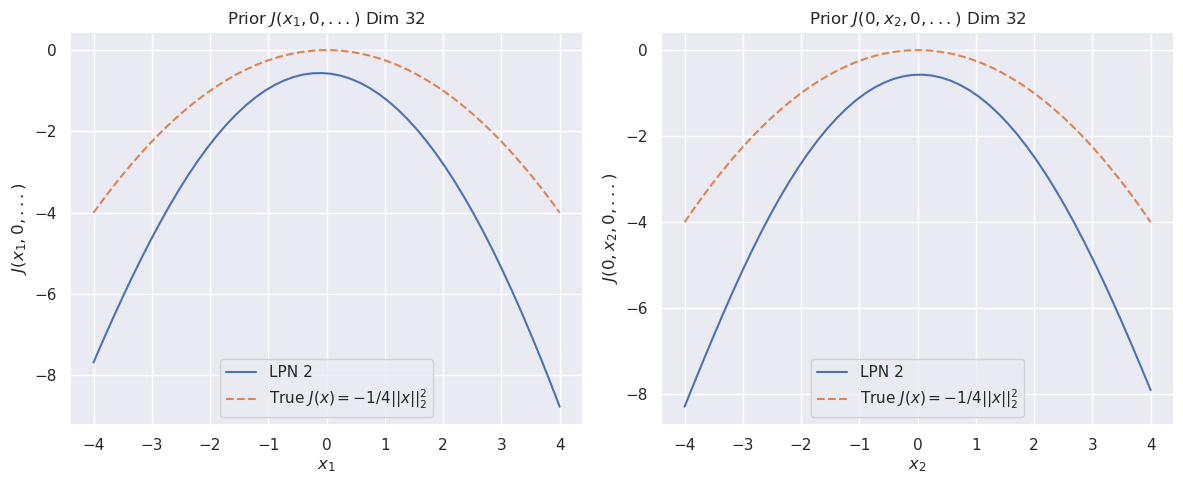

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)